__Handwritten Digits Recognition__ using __SVM__ and __HoG features__ and varying the number of
training/testing images with pre-processing of the images. 
A _grid-search_ on __C__ and __gamma__ is also carried out.


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [17]:
# Constants:
SIZE_IMAGE = 20
NUMBER_CLASSES = 10


def load_digits_and_labels(big_image):
    """ Returns all the digits from the 'big' image and creates the corresponding labels for each image"""

    # Load the 'big' image containing all the digits:
    digits_img = cv2.imread(big_image, 0)

    # Get all the digit images from the 'big' image:
    number_rows = digits_img.shape[1] / SIZE_IMAGE
    rows = np.vsplit(digits_img, digits_img.shape[0] / SIZE_IMAGE)

    digits = []
    for row in rows:
        row_cells = np.hsplit(row, number_rows)
        for digit in row_cells:
            digits.append(digit)
    digits = np.array(digits)

    # Create the labels for each image:
    labels = np.repeat(np.arange(NUMBER_CLASSES), len(digits) / NUMBER_CLASSES)
    return digits, labels


def deskew(img):
    """Pre-processing of the images"""

    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5 * SIZE_IMAGE * skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SIZE_IMAGE, SIZE_IMAGE), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

In [18]:
def svm_init(C=12.5, gamma=0.50625):
    """Creates empty model and assigns main parameters"""

    model = cv2.ml.SVM_create()
    model.setGamma(gamma)
    model.setC(C)
    model.setKernel(cv2.ml.SVM_RBF)
    model.setType(cv2.ml.SVM_C_SVC)
    model.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6))

    return model


def svm_train(model, samples, responses):
    """Returns the trained SVM model based on the samples and responses"""

    model.train(samples, cv2.ml.ROW_SAMPLE, responses)
    return model


def svm_predict(model, samples):
    """Returns the predictions"""

    return model.predict(samples)[1].ravel()


def svm_evaluate(model, samples, labels):
    """Returns SVM evaluation (accuracy)"""

    predictions = svm_predict(model, samples)
    accuracy = (labels == predictions).mean()
    # print('Percentage Accuracy: %.2f %%' % (accuracy * 100))
    return accuracy * 100

In [19]:
def get_hog():
    # cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, histogramNormType,
    # L2HysThreshold, gammaCorrection, nlevels, signedGradient)
    hog = cv2.HOGDescriptor((SIZE_IMAGE, SIZE_IMAGE), (8, 8), (4, 4), (8, 8), 9, 1, -1, 0, 0.2, 1, 64, True)

    print("get descriptor size: {}".format(hog.getDescriptorSize()))
    return hog


def raw_pixels(img):
    return img.flatten()

In [20]:
# Loading all the digits and the corresponding labels:
digits, labels = load_digits_and_labels('images/digits.png')

# Shuffling data
# Constructs a random number generator:
rand = np.random.RandomState(1234)
# Randomly permute the sequence:
shuffle = rand.permutation(len(digits))
digits, labels = digits[shuffle], labels[shuffle]

In [21]:
# HoG feature descriptor:
hog = get_hog()

# Compute the descriptors for all the images.
# In this case, the HoG descriptor is calculated
hog_descriptors = []
for img in digits:
    hog_descriptors.append(hog.compute(deskew(img)))
hog_descriptors = np.squeeze(hog_descriptors)

# At this point we split the data into training and testing (50% for each one):
partition = int(0.9 * len(hog_descriptors))
hog_descriptors_train, hog_descriptors_test = np.split(hog_descriptors, [partition])
labels_train, labels_test = np.split(labels, [partition])

get descriptor size: 144


Training SVM model ...
Accuracy (C=1.00, Gamma=0.1) 98.8
Accuracy (C=1.00, Gamma=0.3) 98.8
Accuracy (C=1.00, Gamma=0.5) 98.2
Accuracy (C=1.00, Gamma=0.7) 98.4
Accuracy (C=1.00, Gamma=0.9) 98.4
Accuracy (C=1.00, Gamma=1.1) 98.4
Accuracy (C=1.00, Gamma=1.3) 98.4
Accuracy (C=1.00, Gamma=1.5) 98.2
Accuracy (C=10.00, Gamma=0.1) 99.2
Accuracy (C=10.00, Gamma=0.3) 99.2
Accuracy (C=10.00, Gamma=0.5) 99.0
Accuracy (C=10.00, Gamma=0.7) 98.8
Accuracy (C=10.00, Gamma=0.9) 98.6
Accuracy (C=10.00, Gamma=1.1) 98.4
Accuracy (C=10.00, Gamma=1.3) 98.4
Accuracy (C=10.00, Gamma=1.5) 98.4
Accuracy (C=100.00, Gamma=0.1) 98.8
Accuracy (C=100.00, Gamma=0.3) 99.2
Accuracy (C=100.00, Gamma=0.5) 99.0
Accuracy (C=100.00, Gamma=0.7) 98.8
Accuracy (C=100.00, Gamma=0.9) 98.6
Accuracy (C=100.00, Gamma=1.1) 98.4
Accuracy (C=100.00, Gamma=1.3) 98.4
Accuracy (C=100.00, Gamma=1.5) 98.4
Accuracy (C=1000.00, Gamma=0.1) 98.8
Accuracy (C=1000.00, Gamma=0.3) 99.2
Accuracy (C=1000.00, Gamma=0.5) 99.0
Accuracy (C=1000.00, Gamma

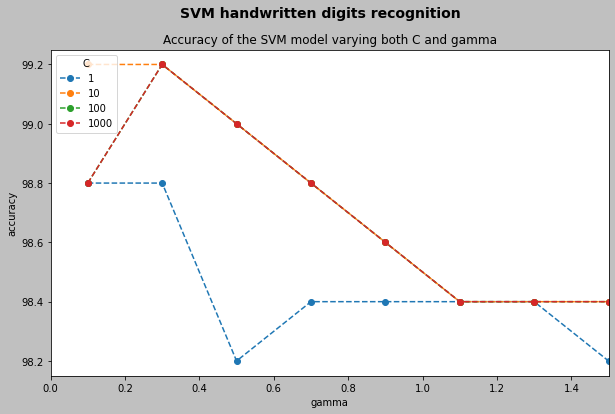

In [22]:
print('Training SVM model ...')
# Create a dictionary to store the accuracy when testing:
results = defaultdict(list)

for C in [1, 10, 100, 1000]:
    for gamma in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]:
        model = svm_init(C, gamma)
        svm_train(model, hog_descriptors_train, labels_train)
        acc = svm_evaluate(model, hog_descriptors_test, labels_test)
        print("Accuracy (C={}, Gamma={}) {}".format("%.2f" % C, gamma, acc))
        results[C].append(acc)

# Create the dimensions of the figure and set title:
fig = plt.figure(figsize=(10, 6))
plt.suptitle("SVM handwritten digits recognition", fontsize=14, fontweight='bold')
fig.patch.set_facecolor('silver')

# Show all results using matplotlib capabilities:
ax = plt.subplot(1, 1, 1)
ax.set_xlim(0, 1.5)
dim = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]

for key in results:
    ax.plot(dim, results[key], linestyle='--', marker='o', label=str(key))

plt.legend(loc='upper left', title="C")
plt.title('Accuracy of the SVM model varying both C and gamma')
plt.xlabel("gamma")
plt.ylabel("accuracy")
plt.show()